# Mori Zwanzig for Koopman approximation

## Introduction

For high-dimensional stochastic systems, computing or storing the full Koopman operator is impractical. 
The key insight is that the dynamics of a subset of variables can be described exactly by a generalized Langevin equation (GLE) that includes non-Markovian memory effects and noise arising from the unresolved degrees of freedom.

### Why Mori Zwanzig?

Mori Zwanzig extends eDMD by:
- **Adding Memory**: Using memory of the observables 
- **Koopman operator theory**: providing memory closure to infinite dimensional Koopman operator
- **Reduced Order Model**: Better representation of complex, nonlinear systems with fewer modes

### This Notebook

We will explore:
- Mori Zwanzig algorithm for Stuart-Landau equation
- Predictive modeling

---

### Generalised Langevin Equation

The Generalised Langevin Equation for observables is expressed as follows,

$$

\begin{align}
        d_t \mathbf{f}_t&=\mathbf{A}\mathbf{f}_t+\int_0^t  \mathbf{B}_{t-s}\mathbf{f}_s \; ds+\mathbf{F}_t, \;\;\;\; \mathbf{f}_0=\mathbf{f}, \\
\end{align}
\\

$$

with:

$$
\\
\begin{equation} 
\mathbf{A}=\mathbf{P}(\mathcal{K}\mathbf{f}),\;\;\;\; \mathbf{B}_s=\mathbf{Q}(\mathcal{K}\mathbf{f})e^{\mathbf{Q}(\mathcal{K}\mathbf{\tilde{f}})s}\mathbf{P}(\mathcal{K}\mathbf{\tilde{f}}), \;\;\;\;
\mathbf{F}_t=\mathbf{Q}(\mathcal{K}\mathbf{f})e^{\mathbf{Q}(\mathcal{K}\mathbf{\tilde{f}})t}\mathbf{\tilde{f}}.
\end{equation}

$$


We can obtain the discrete form of generalised Langevin equation as follows:

\begin{align}
        \mathbf{f}_{t+1} = \mathbf{A}\mathbf{f}_{t} + \sum_{s=1}^{t}\mathbf{B}_{t-s}\mathbf{f}_{s} + \mathbf{F}_{t}, \\
\end{align}

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('/home/pg221/PhD_projects3/DMD_for_chapter/')

We take Stuart-Landau equations as example
```markdown

Stuart-Landau Oscillator

The Stuart-Landau equation is a canonical model for studying nonlinear oscillations and bifurcations. It describes the dynamics of a complex amplitude A in the form:

```
$$
\begin{align}
   \frac{dA}{dt}&= \delta A-\mu A|A|^2,
\end{align}
$$

where $\delta$ is a control parameter that separates a stable region $(\delta < 0)$ for the fixed point $A = 0$ from an unstable one $ \delta>0$, and $ \mu $ is a complex constant. For the following numerical setup we consider, $ \delta = 0.1 $ and $ \omega = 3.0 $

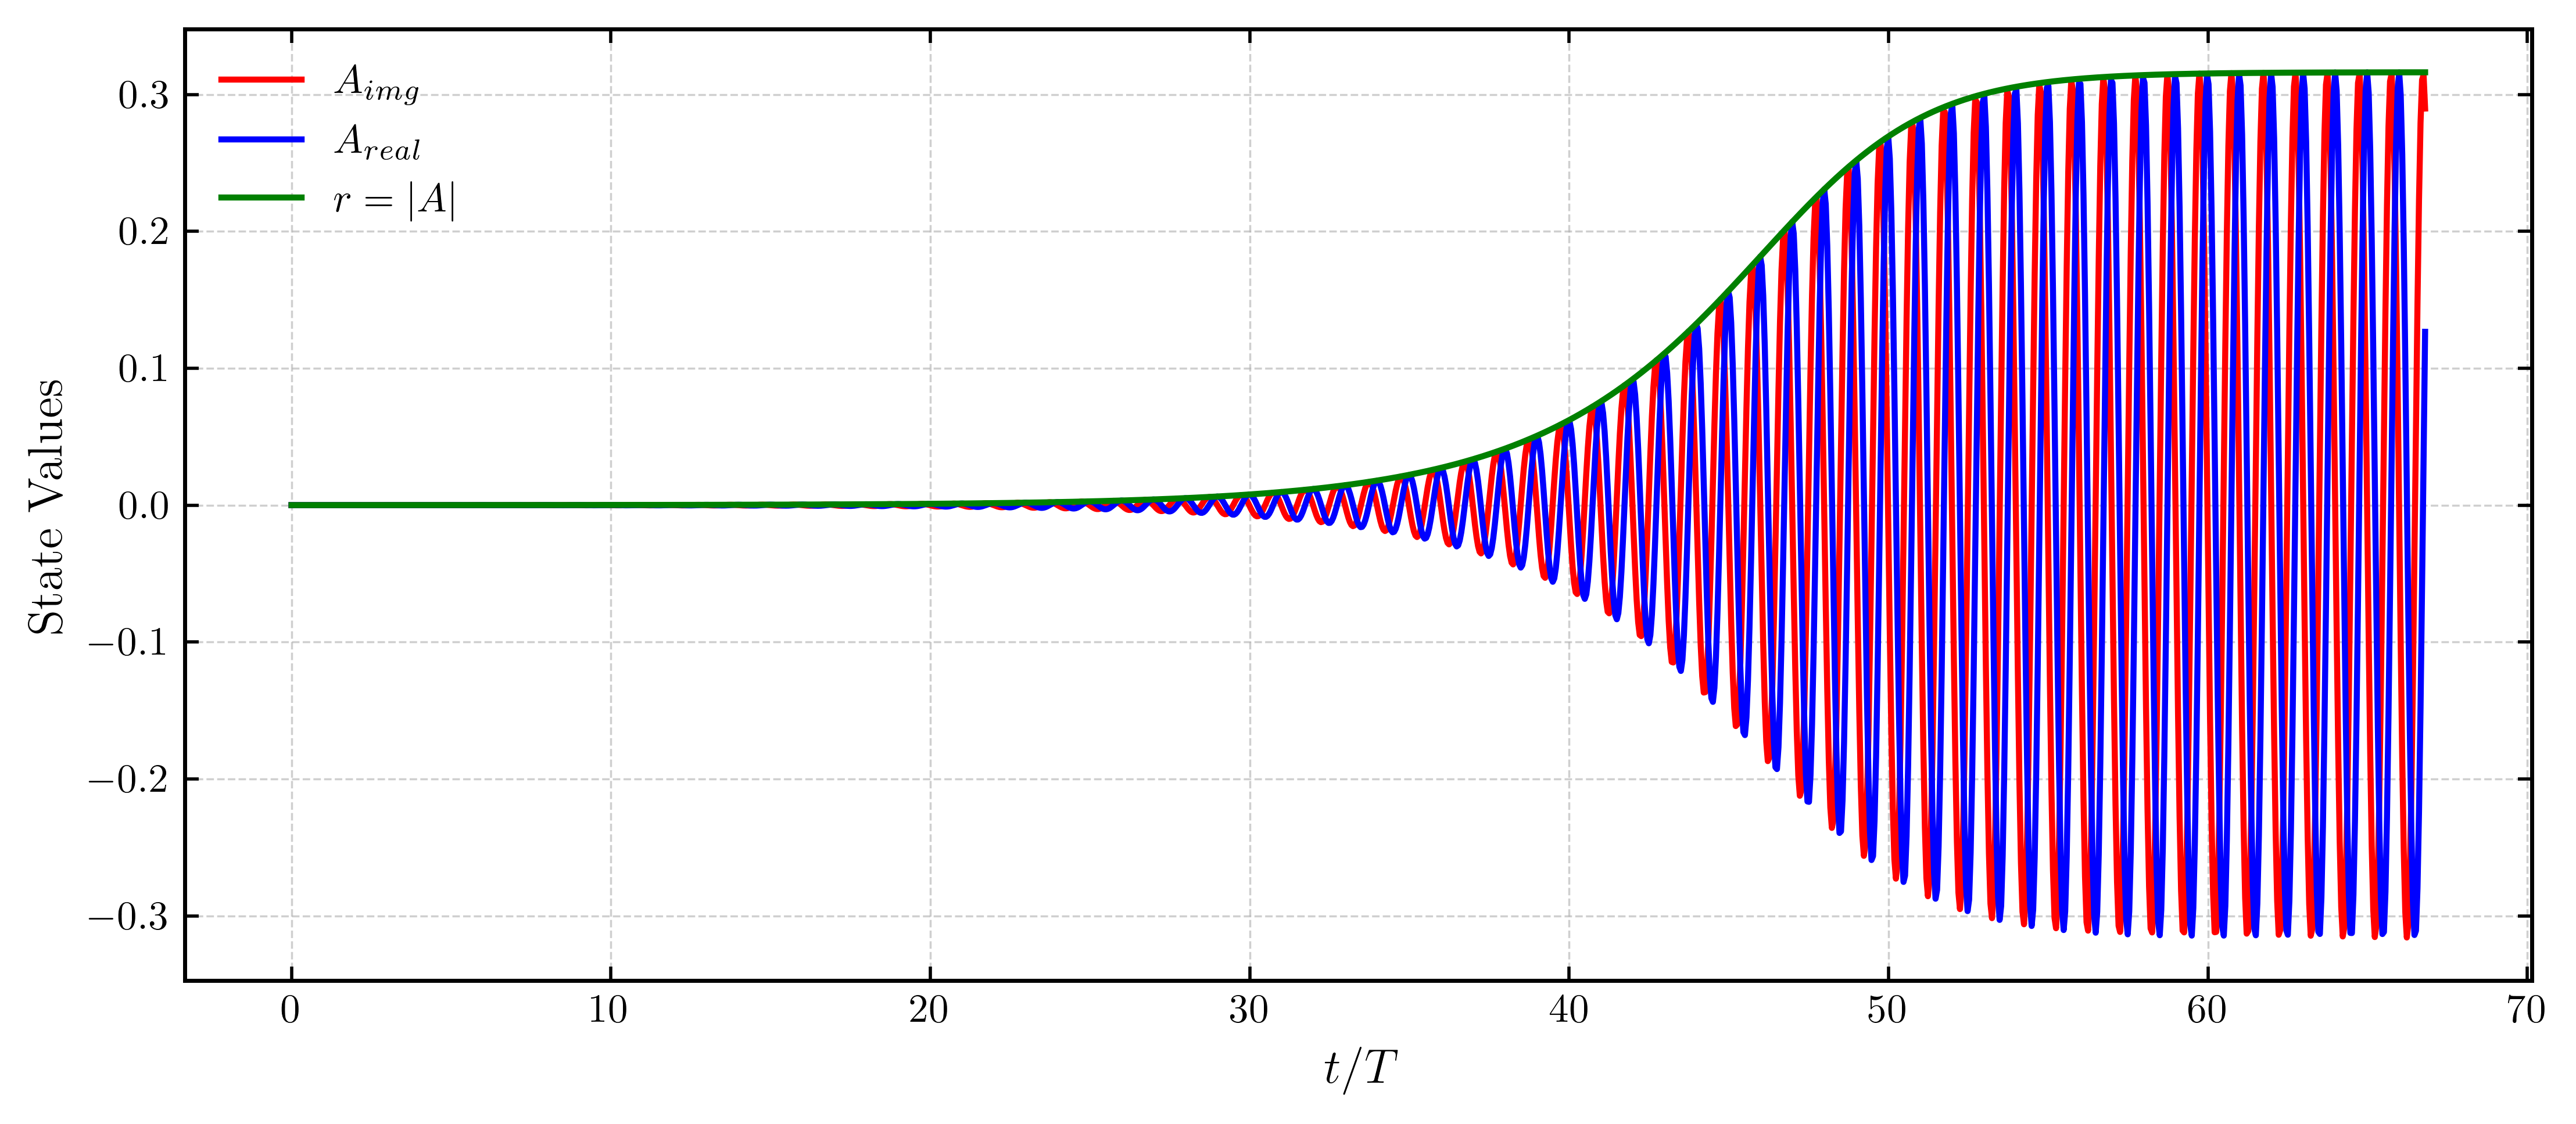

In [5]:
from osc_envs.osc_gym import OscillatorEnv

dt = 0.1
omega = 3.0
env = OscillatorEnv(params={"amplitude": 0.3, "initial_transition_steps": 2})

states = np.array([]).reshape(0, env.observation_space.shape[0])
time_steps = 2000

env.reset()
for j in range(time_steps):
    state , reward, _,_,_ = env.step(action = np.zeros(env.action_space.shape))
    states = np.vstack([states, state])



from matplotlib import rcParams
# ====== Plot ======
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 11,          # main text font = 10 pt
    "axes.labelsize": 12,     # ≈ 1.1× main text
    "xtick.labelsize": 10,     # ≈ 0.9×
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "figure.figsize": (9, 4),
    "savefig.dpi": 500,
    "savefig.bbox": "tight",
})

freq = omega/(2* np.pi)
T = 1/freq
t = np.arange(time_steps) * dt/T

fig, ax = plt.subplots(dpi = 500)
obs = [r"$A_{img}$", r"$A_{real}$", r"$r = |A|$"]
colors = ["r","blue","green"]
for i in range(states.shape[1]):
    ax.plot(t[:1400], states[:1400,i][:], label=obs[i], color=colors[i])

ax.set_xlabel(r'$t/T$')
ax.set_ylabel('State Values')
ax.legend(frameon=False)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.tight_layout()


This system is fully described by the states $A_{\text{img}},\; A_{\text{real}}$. To see Mori-Zwanzig at work we resolve only one observable and model the effect of unresolved observables as memory of the resolved observable,
$$
\begin{equation}
    \mathbf{f} = \left[A_{\text{img}}\right]
\end{equation}
$$

The algorithm proceeds as follows.
Assume we have $n_t$ snapshots $\mathbf{f}_{t=0,\cdots,n_t-1}$ at times $t\Delta t$.
The objective is to find a finite-dimensional matrix $\mathbf{A}$ and corresponding memory kernels $ \mathbf{B}_s, \forall s \in 1,...,q $ such that:
$$
\mathbf{f}_t = \mathbf{A}\mathbf{f}_{t-1} + \sum_{j=1}^{q}\mathbf{B}_j\mathbf{f}_{t-j}, \quad t = 1, \cdots, n_t - 1.
$$

Here, $ q $ represents the prescribed memory length for the model.

(800, 1)


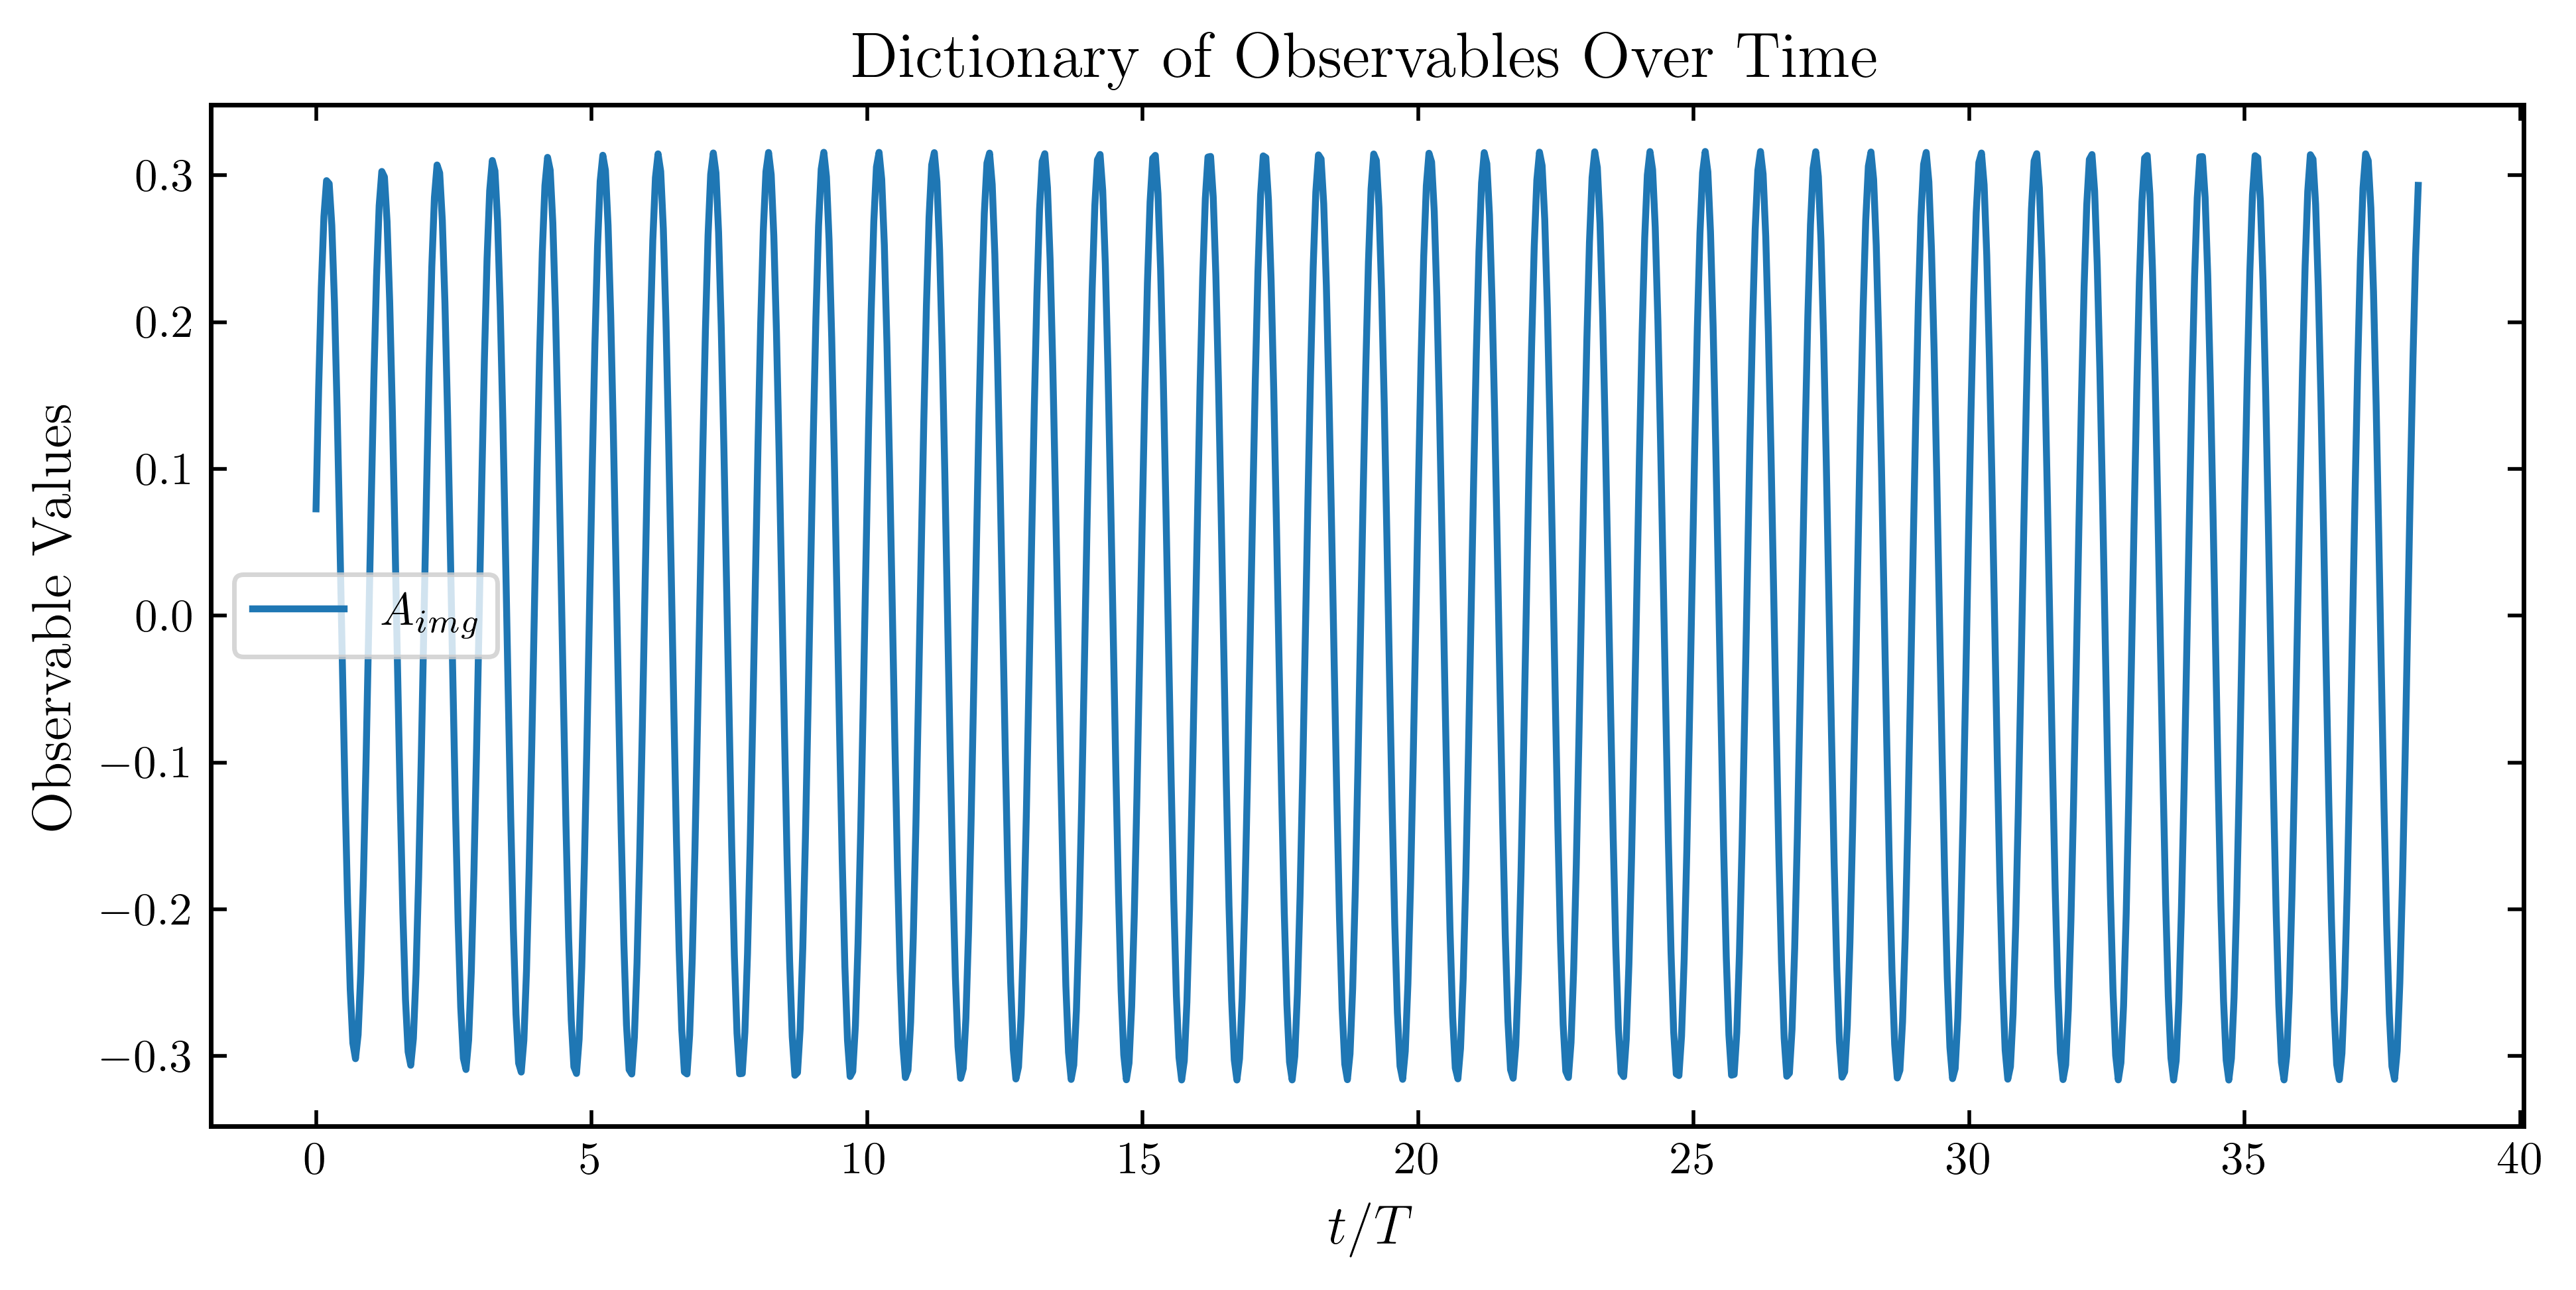

In [6]:
#Dictionary construction
obs_dict = np.vstack([states[:,0]]).T
obs_dict.shape

obss= [r"$A_{img}$"]
# obs_dict = np.vstack([states[:,0], states[:,1]]).T
obs_dict = obs_dict[1100:1900]
print(obs_dict.shape)

freq = omega/(2* np.pi)
T = 1/freq
t = np.arange(obs_dict.shape[0]) * dt/T

plt.figure(dpi=500)
for i in range(obs_dict.shape[1]):
    plt.plot(t, obs_dict[:,i], label=obss[i])

plt.ylabel('Observable Values')
plt.xlabel(r'$t/T$')
plt.title('Dictionary of Observables Over Time')
plt.legend(frameon=True)


In the following section we show the implementation of the algortihm presented in "Data-based learning of memory-term based on noise" section of the chapter.

In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm

class Mori_Zwanzig_with_Fluctuation_Dissipation():
    
    def __init__(self, markov_model=None):
        self.markov_model = markov_model

    def create_sequences(self, data, sequence_length):
        sequences = torch.zeros((len(data) - sequence_length,sequence_length,data.shape[-1]))
        targets = torch.zeros((len(data) - sequence_length, data.shape[-1]), dtype = torch.float32)
        for i in range(len(data) - sequence_length):
            seq = torch.tensor(data[i:i+sequence_length], dtype = torch.float32) 
            target = torch.tensor(data[i+sequence_length], dtype = torch.float32)  
            sequences[i] = seq
            targets[i]   = target
        return torch.tensor(sequences, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32)

    def get_observables_data(self, data, num_memory_kernels):
        sequences, targets = self.create_sequences(data, sequence_length = num_memory_kernels+2)

        model_num = 0
        # generate encoded data
        batch_size, seqlen, state_dim = sequences.shape
        sequences = sequences.view(-1, state_dim) 
        sequences   = sequences.view(batch_size, seqlen, state_dim)
                
        return sequences

    def gfdc_memory_reg(self, xn_data, num_memory_kernels, alpha = 10, fit_intercept = False):
        
        print("xn_data.shape: ", xn_data.shape)
        K = num_memory_kernels
        if self.markov_model is not None:
            omega = [self.markov_model.model.koopman]
        else:
            markov_model = Ridge(alpha=alpha, fit_intercept=fit_intercept)
            markov_model.fit(xn_data[:,0], xn_data[:,1])
            omega = [markov_model]

        #initialise memory kernels
        for i in range(1,K+1):
            omega.append(Ridge(alpha=alpha, fit_intercept=fit_intercept))
            
        for n in tqdm(range(1,K+1), desc = "num_memory kernels: "):
            yr = np.zeros((xn_data.shape[0], xn_data.shape[-1]))
            for l in range(n):
                if xn_data.shape[-1] > 1:
                    yr += omega[l].predict(xn_data[:,n-l])
                else:
                    yr += omega[l].predict(xn_data[:,n-l])[:,np.newaxis]
            y = xn_data[:,n+1] - yr
            omega[n].fit(xn_data[:,0], y)
                
        self.omega = omega
        return omega
    
    def predict(self, initial_condition, timesteps = 100, num_kernels = 10, omega = None):
        """
        initial_condition: [batchsize num_kernels+1 statedim]
        timesteps: int
        num_kernels: int
        omega: list of kernel models
        """
        def next_step(input_, num_kernels):
            """
            input_: [batchsize seqlen statedim]
            output: [batchsize 1 statedim]
            """
            output = np.zeros((input_.shape[0],*input_.shape[2:]))
            state_dim = input_.shape[-1]

            for i in range(num_kernels):
                if state_dim > 1:
                    kernel_output =  omega[i].predict(input_[:,num_kernels-i-1])
                else:
                    kernel_output =  omega[i].predict(input_[:,num_kernels-i-1])[:,np.newaxis]
                output += kernel_output
            return output

        pred_data = []
        xn = initial_condition 
        pred_data = xn
        for t in range(timesteps):
            xnn = next_step(xn, num_kernels+1) 
            pred_data = np.concatenate((pred_data, xnn[:,np.newaxis]), axis=1)

            xn = pred_data[:,-(num_kernels+1):]

        return pred_data


In [8]:
def get_predicted_data_and_omega(obs_dict, num_memory_kernels, alpha=20, timesteps=800):
    L = num_memory_kernels+1
    gfdc = Mori_Zwanzig_with_Fluctuation_Dissipation()
    sequences = gfdc.get_observables_data(obs_dict, num_memory_kernels).numpy()
    print("sequences shape: ", sequences.shape)

    # omega = gfdc.gfdc_memory_reg(sequences, num_memory_kernels, alpha=96)
    # omega = gfdc.gfdc_memory_reg(sequences, num_memory_kernels, alpha=118)
    omega = gfdc.gfdc_memory_reg(sequences, num_memory_kernels, alpha=alpha)


    predicted_data = gfdc.predict(initial_condition=sequences[:2,:num_memory_kernels+1,:], timesteps=timesteps, num_kernels=num_memory_kernels, omega=omega)
    print("predicted_data shape: ", predicted_data.shape)

    error = np.mean((predicted_data[0,L:] - obs_dict[L:L+timesteps])**2)
    print("Prediction error: ", error)
    return predicted_data, omega, error

num_memory_kernels = 30
num_obs = 1
pred_timesteps = 200
data = obs_dict[:,:num_obs]
# predicted_data, omega, error = get_predicted_data_and_omega(data, num_memory_kernels, alpha=46, timesteps=pred_timesteps)
predicted_data_with_memory, omega, error = get_predicted_data_and_omega(data, num_memory_kernels, alpha=80, timesteps=pred_timesteps)
predicted_data_without_memory, omega_no_memory, error_no_memory = get_predicted_data_and_omega(data, num_memory_kernels=0, alpha=80, timesteps=pred_timesteps)


/tmp/ipykernel_2134462/2646666882.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequences, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32)


sequences shape:  (768, 32, 1)
xn_data.shape:  (768, 32, 1)


num_memory kernels: 100%|██████████| 30/30 [00:00<00:00, 503.12it/s]
/tmp/ipykernel_2134462/2646666882.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sequences, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32)


predicted_data shape:  (2, 231, 1)
Prediction error:  0.0001972226657752631
sequences shape:  (798, 2, 1)
xn_data.shape:  (798, 2, 1)


num_memory kernels: : 0it [00:00, ?it/s]

predicted_data shape:  (2, 201, 1)
Prediction error:  0.048294362376558


We plot the predicted trajectories using Mori-Zwanzig and without Mori-Zwanzig. We observe that memory kernels enable prediction of resolved observables over time.

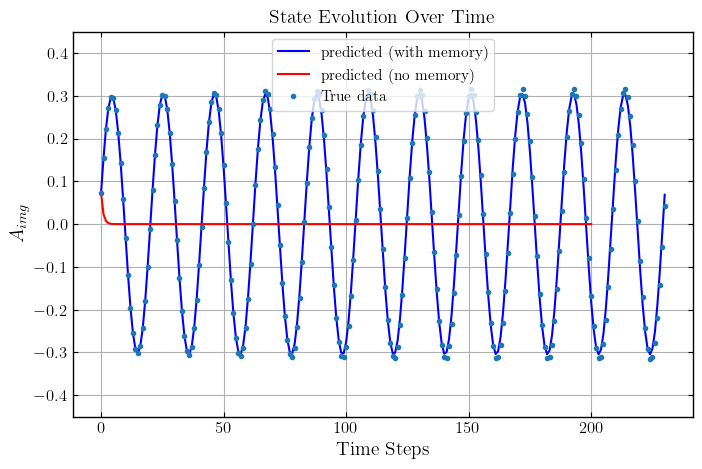

In [16]:
from matplotlib import rcParams

# JFM style plot settings
rcParams.update({
    "font.family": "serif",
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 11,
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,
    "figure.figsize": (8, 5),
    "savefig.dpi": 500,
    "savefig.bbox": "tight",
})

#Figure for prediction
L = num_memory_kernels+1
plt.figure()
# for i, alpha in enumerate([alphas[18]]):
plt.plot(predicted_data_with_memory[0,:,0], color = "blue", label = "predicted (with memory)")
plt.plot(predicted_data_without_memory[0,:,0], color= "red", label = "predicted (no memory)")
plt.plot(data[:L+pred_timesteps,0][:], '.', label=f'True data')
plt.xlabel('Time Steps')
plt.ylabel(r'$A_{img}$')
plt.title(f'State Evolution Over Time')
plt.ylim(-0.45,0.45)
plt.legend()
plt.grid()
plt.show()

We also plot the memory kernels to show memory decay over time.

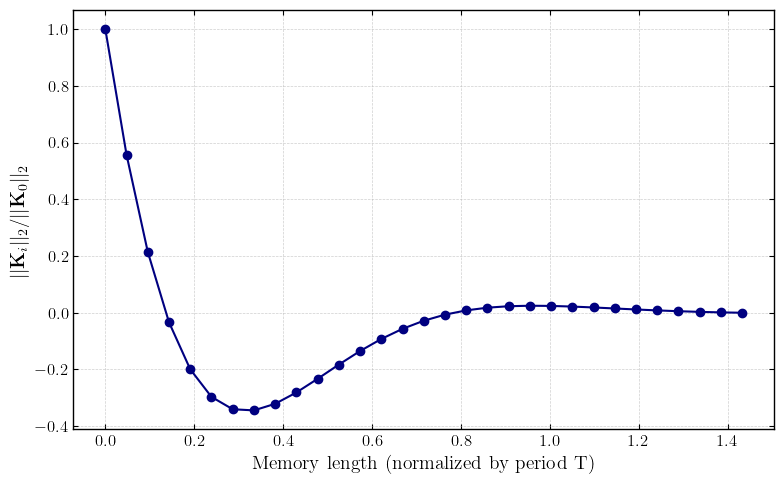

In [8]:
kernel_norms = []
model0_norm = omega[0].coef_
for model in omega:
    norm = model.coef_
    kernel_norms.append(norm/model0_norm)
# model0_norm = omega[0].coef_
# for model in omega:
#     norm = model.coef_
#     kernel_norms.append(norm/model0_norm)

fig, ax = plt.subplots()

w = 3.0
dt=0.1
freq = w/(2* np.pi)
T = 1/freq
t = np.arange(num_memory_kernels+1) * dt/T

ax.plot(t, kernel_norms, marker='o', linestyle='-', color='navy')

ax.set_xlabel('Memory length (normalized by period T)')
ax.set_ylabel(r'$||\mathbf{K}_i||_2/||\mathbf{K}_0||_2$')
# ax.set_xticks(range(len(kernel_norms)))
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()